In [1]:
from glob import glob
from PIL import Image
import pandas as pd
import numpy as np
import re
import math
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from keras.models import Model, Sequential

In [2]:
# 參數
# 決定要把讀進來的照片resize的程度
img_rows = 600
img_cols = 300
channels = 3
# tuple, http://jialin128.pixnet.net/blog/post/159074609-%5Bpython%5D-%E4%B8%B2%E5%88%97%28list%29%E8%88%87%E5%85%83%E7%B5%84%28tuple%29%E6%AF%94%E8%BC%83
img_size = (img_rows, img_cols, channels)
# 給 array用
img_size_np = (img_cols, img_rows, channels)

### Load label and picture

In [3]:
street_df = pd.read_csv('../0703/all_geo.csv')
land_df = pd.read_csv('../0703/all_lat.csv')

c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
street_df.head()

,address,lat,lng
0,新北市板橋區華東街271~300號,25.001936,121.452653
1,新北市土城區永豐路121~150號,24.984078,121.466060
2,新北市板橋區新崑路91~120號,24.999177,121.432317
3,新北市土城區延和路76巷1~30號,24.989084,121.466463
4,新北市板橋區中山路一段181~210號,25.013187,121.467601


In [4]:
# 找哪個區目前有的照片最多
for index, row in street_df.iterrows():
    # 切割市 & 區
    pattern = re.split('市', re.split('區', row['address'])[0])[1]
    street_df.loc[index, 'section'] = pattern

In [35]:
# 查看哪區最多
street_df['section'].value_counts()

板橋    550
中和    536
新莊    519
三重    422
新店    391
淡水    356
汐止    320
土城    282
永和    266
蘆洲    228
林口    222
樹林    205
三峽    144
鶯歌    115
五股    114
泰山    104
瑞芳     50
八里     45
三芝     43
深坑     36
萬里     20
金山     19
貢寮      5
石門      3
雙溪      3
烏來      1
石碇      1
Name: section, dtype: int64

`新北市板橋區華東街271~300號` 兩年交易110次
> https://www.leju.com.tw/page_search_result?oid=Lb7d85292713c4

In [15]:
test = pd.DataFrame(columns=['address', 'price', 'area'])
# 找出地址符合street前5000的，並幫street標上售價
for i, item in street_df[:5000].loc[street_df[:5000]['section'] == '板橋'].iterrows():
    for j, price in land_df.loc[land_df['土地區段位置/建物區段門牌'] == item['address']].iterrows():
        test.loc[len(test), ['address', 'price', 'area']] = item['address'], price['總價元'], price['建物移轉總面積平方公尺']

In [18]:
test.head()

,address,price,area,imgs
0,新北市板橋區華東街271~300號,15000000,95.26,../0806/land_streetView\120degree\新北市板橋區華東街241...
1,新北市板橋區華東街271~300號,32680000,212.13,../0806/land_streetView\120degree\新北市板橋區華東街241...
2,新北市板橋區華東街271~300號,22770000,152.97,../0806/land_streetView\120degree\新北市板橋區華東街241...
3,新北市板橋區華東街271~300號,17100000,122.89,../0806/land_streetView\120degree\新北市板橋區華東街241...
4,新北市板橋區華東街271~300號,15420000,97.63,../0806/land_streetView\120degree\新北市板橋區華東街241...


In [16]:
train_pic = []
label = []

### 判斷每個地址有幾張圖

In [8]:
%%time

# for m, data in street_df.head().iterrows():
for m, data in street_df[:5000].loc[street_df[:5000]['section'] == '板橋'].iterrows():
    backup_num = []
    try:
        address_num = re.findall('\d+', data['address'])
        if(len(re.findall('\d+', data['address'])) > 2):
            # 存大於2個的數值(有巷/弄)
            backup_num = address_num
            # 取倒數兩個
            address_num = address_num[-2:]

        size = math.ceil((int(address_num[1]) - int(address_num[0]))/10)
        address_split = re.split('\d+', data['address'])
        address_split.remove('~')
        address_split.remove('號')
        address_template = ''.join(address_split)
        if(len(backup_num) == 3):
            #有巷
            address_split[0] = address_split[0] + backup_num[0]
            address_template = ''.join(address_split)
        if(len(backup_num) == 4):
            # 有巷也有弄
            address_split[0] = address_split[0] + backup_num[0]
            address_split[1] = address_split[1] + backup_num[1]
            address_template = ''.join(address_split)

        img_path_list = glob('../0806/land_streetView/*degree/' + address_template + '*.jpg')
        match_list = [] # 記錄有幾種照片符合規則
        price_list = [] # 此地址有多少種售價(有幾筆交易紀錄)
        for img in img_path_list:
            pattern = re.compile(address_template + '\d+號')
            if pattern.search(img):
                match_list.append(img)
                
#         print(len(match_list))
                
        for w, data in test.iterrows():
            pattern = re.compile(address_template + '\d+\~\d+號')
            if pattern.search(data['address']):
                price_list.append(data['price'])

        # 處理label, 根據有幾張圖，決定要給幾次一樣的label
        # 一個地址有多少種prcie
        for k in range(0, len(price_list)):
            # 紀錄單一地址對應到哪些照片路徑
            train_pic.append(match_list)
            
            # 每種售價有幾張照片
            for index in range(0, len(match_list)):
                # 填上label
                label.append(price_list[k])
        
    except Exception as e:
        print(e)
        continue

# list to numpy array
label = np.array(label)
train_pic = np.array(train_pic)

Wall time: 2min 53s


嘗試加速上面的計算方式

In [17]:
%%time

# 從 streetDF找出 unique地址有幾張照片符合，並記錄到 testDF
# for m, data in street_df[:1000].loc[street_df[:1000]['section'] == '板橋'].iterrows():
for m, data in street_df[:5000].loc[street_df[:5000]['section'] == '板橋'].iterrows():
    backup_num = []
    try:
        address_num = re.findall('\d+', data['address'])
        if(len(re.findall('\d+', data['address'])) > 2):
            # 存大於2個的數值(有巷/弄)
            backup_num = address_num
            # 取倒數兩個
            address_num = address_num[-2:]

        size = math.ceil((int(address_num[1]) - int(address_num[0]))/10)
        address_split = re.split('\d+', data['address'])
        address_split.remove('~')
        address_split.remove('號')
        address_template = ''.join(address_split)
        if(len(backup_num) == 3):
            #有巷
            address_split[0] = address_split[0] + backup_num[0]
            address_template = ''.join(address_split)
        if(len(backup_num) == 4):
            # 有巷也有弄
            address_split[0] = address_split[0] + backup_num[0]
            address_split[1] = address_split[1] + backup_num[1]
            address_template = ''.join(address_split)

        img_path_list = glob('../0806/land_streetView/*degree/' + address_template + '*.jpg')
        match_list = [] # 記錄有幾種照片符合規則
        price_list = [] # 此地址有多少種售價(有幾筆交易紀錄)
        for img in img_path_list:
            pattern = re.compile(address_template + '\d+號')
            if pattern.search(img):
                match_list.append(img)
                
        if not len(match_list) == 0:
            test.loc[test['address'] == data['address'], 'imgs'] = ','.join(match_list)
        else:
            test.loc[test['address'] == data['address'], 'imgs'] = ''
                
    except Exception as e:
        print(e)
        continue

Wall time: 54.6 s


In [107]:
test.head()

,address,price,imgs
0,新北市板橋區華東街271~300號,15000000.0,../0806/land_streetView\120degree\新北市板橋區華東街241...
1,新北市板橋區華東街271~300號,32680000.0,../0806/land_streetView\120degree\新北市板橋區華東街241...
2,新北市板橋區華東街271~300號,22770000.0,../0806/land_streetView\120degree\新北市板橋區華東街241...
3,新北市板橋區華東街271~300號,17100000.0,../0806/land_streetView\120degree\新北市板橋區華東街241...
4,新北市板橋區華東街271~300號,15420000.0,../0806/land_streetView\120degree\新北市板橋區華東街241...


In [18]:
area = []

In [19]:
# 紀錄一個地址被交易幾次
address_count = test['address'].value_counts().to_frame().rename(columns={"address": "count"}).rename_axis('address').reset_index()
# 根據單一地址被交易次數與照片數，建立 train_pic list
for i, data in test.iterrows():
    if not data['imgs']=='':
        train_pic.extend(data['imgs'].split(','))
        # 根據 testDF同地址的不同價格數目與 unique地址的圖片產生label
        label.extend([data['price']]*len(data['imgs'].split(',')))
        area.extend([data['area']]*len(data['imgs'].split(',')))

In [68]:
address_count.head()

,address,count
0,新北市板橋區三民路一段145巷1~30號,4
1,新北市板橋區三民路一段151~180號,2
2,新北市板橋區三民路一段181~210號,2
3,新北市板橋區三民路一段1巷1~30號,2
4,新北市板橋區三民路一段1巷31~60號,1


In [32]:
# 獨立路段總共被交易次數
print(train_pic.shape)

# 第一個交易紀錄的照片數
print(len(train_pic[0]))

(2098,)
24


In [165]:
sum = 0
for i, j in enumerate(train_pic):
    sum = sum + len(j)
print(sum)

# size要一致
print(label.shape)

608281
(608281,)


python讀圖與numpy
> https://blog.csdn.net/majinlei121/article/details/78933947

array和asarray都可以將結構數據轉化為ndarray，但是主要區別就是當數據源是ndarray時，array仍然會copy出一個副本，佔用新的內存，但asarray不會。

image shape in PIL and np array are different
> https://github.com/python-pillow/Pillow/issues/2619

In [43]:
train_pic[0][0]

'../0806/land_streetView\\120degree\\新北市板橋區華東街241號_120.jpg'

PIL 跟np array
> https://kite.com/python/examples/4887/pil-convert-between-a-pil-image-and-a-numpy-array

reshape image
> http://code.activestate.com/recipes/577591-conversion-of-pil-image-and-numpy-array/

In [50]:
img00 = train_pic[0][0]
print(np.array(Image.open(img00).convert('RGB').resize(img_size[:2], Image.ANTIALIAS))[:,:,:3].shape)
print(np.array(Image.open(img00).convert('RGB').resize(img_size[:2], Image.ANTIALIAS)).reshape(img_size[0], img_size[1], 3).shape)
print(np.array(Image.open(img00).convert('RGB').resize(img_size[:2], Image.ANTIALIAS)).transpose(1, 0, 2).shape)

(300, 600, 3)
(600, 300, 3)
(600, 300, 3)


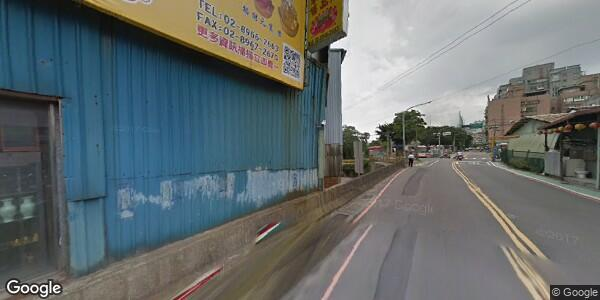

In [17]:
from IPython.display import display
display(Image.open(train_pic[0][0]))

In [55]:
print(np.zeros((label.size, img_cols, img_rows, channels)).shape)
print(np.zeros((label.size, ) + img_size_np).shape)

(5088, 300, 600, 3)
(5088, 300, 600, 3)


In [52]:
(label.size, ) + img_size

(5088, 600, 300, 3)

In [22]:
img_df = pd.DataFrame()

In [10]:
# load image
def load_data(img_res, path_list, size):
    def imread(path, img_res):
        # 使用PIL讀取圖片，然後轉成 np array
        return np.array(Image.open(path).convert('RGB').resize(img_res, Image.ANTIALIAS)) / 255
#         return np.array(Image.open(path).convert('RGB').resize(img_res, Image.ANTIALIAS)).reshape(img_res[0], img_res[1], 3) / 255
    
#     img_set = np.zeros((size, ) + img_size_np,  dtype = np.float16)
    
    for j, land in enumerate(path_list):
        for idx, rand_img_path in enumerate(land):
#             img_set[idx + j] = imread(rand_img_path, img_res[:2])[:,:,:3]
            
#     return img_set

In [ ]:
# 根據test DF處理圖片的形狀(完整的path_list, 第一維的size要跟label一致)
# load_data(img_size, train_pic, label.size)

In [23]:
# 將路徑存到 dataframe
img_df['file_path'] = train_pic
img_df['label'] = label

In [120]:
img_df.head()

,file_path,label
0,../0806/land_streetView\120degree\新北市板橋區華東街241...,15000000.0
1,../0806/land_streetView\120degree\新北市板橋區華東街251...,15000000.0
2,../0806/land_streetView\120degree\新北市板橋區華東街261...,15000000.0
3,../0806/land_streetView\120degree\新北市板橋區華東街270...,15000000.0
4,../0806/land_streetView\120degree\新北市板橋區華東街271...,15000000.0


分批讀圖，免得ram爆炸

>　https://stackoverflow.com/questions/51843149/loading-batches-of-images-in-keras-from-pandas-dataframe/51843972

> https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

In [24]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_dataframe(     
    dataframe=img_df,
    batch_size= 40,
    x_col="file_path", 
    y_col="label",
    target_size = (img_rows, img_cols),
    class_mode="other")

Found 144316 validated image filenames.


### CNN model
> https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

In [27]:
model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=img_size))
model_CNN.add(Conv2D(32, (3, 3), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(4, 4)))
model_CNN.add(Dropout(0.25))
model_CNN.add(Conv2D(32, (5, 5), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Flatten())

model_CNN.add(Dense(32, activation='relu'))
model_CNN.add(Dropout(0.5))
# 預測價格
model_CNN.add(Dense(1, activation='relu'))

model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 596, 296, 64)      4864      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 594, 294, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 73, 32)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 148, 73, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 144, 69, 32)       25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 72, 34, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 78336)             0         
__________

可視化
> https://keras.io/visualization/

> https://www.itread01.com/content/1549993358.html

In [42]:
from IPython.display import Image
import graphviz
from keras.utils.vis_utils import plot_model
import os
# 設定 graphviz的路徑
os.environ["PATH"] += os.pathsep + 'C:\\Users\\Wade\\Anaconda3\\Library\\bin\\graphviz'

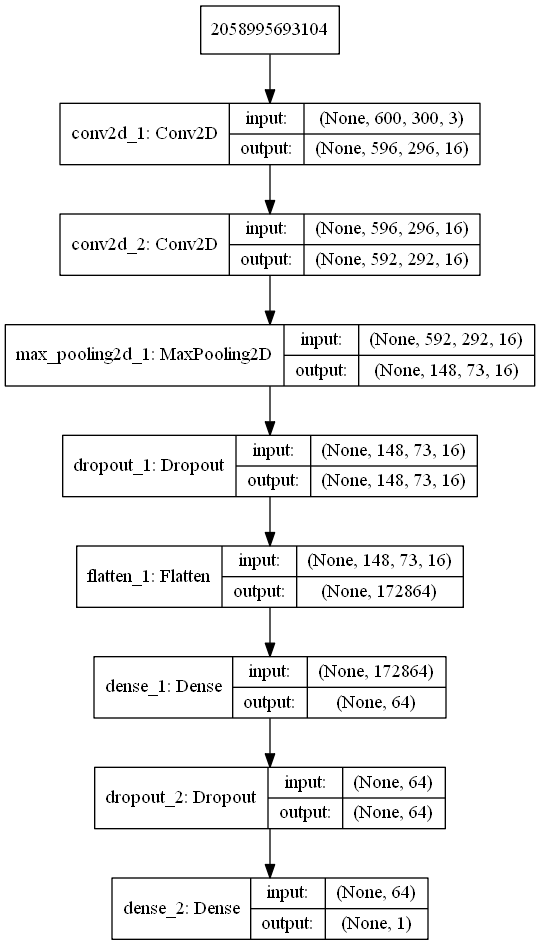

In [42]:
plot_model(model_CNN, to_file = 'model_CNN.png',show_shapes = True)
Image('model_CNN.png')

顯存不夠，已將參數由3E減少至4千萬
> https://github.com/Zehaos/MobileNet/issues/30

In [68]:
model_CNN.compile(loss='mean_absolute_percentage_error', optimizer='adam')
train_history = model_CNN.fit(x=img_data, y=label, validation_split=0.3, epochs=10, batch_size=100, verbose=1)

W0809 17:40:20.332638  4036 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 17:40:20.453632  4036 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 3561 samples, validate on 1527 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[100,16,298,598] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/Adam/gradients/conv2d_10/convolution_grad/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [29]:
model_CNN.compile(loss='mean_absolute_percentage_error', optimizer='adam')
# train_history = model_CNN.fit(x=img_data, y=label, validation_split=0.3, epochs=10, batch_size=10, verbose=0)
train_history = model_CNN.fit_generator(train_generator, epochs=3, steps_per_epoch=img_df.shape[0]/ 40, verbose=1)

Epoch 1/3
3608/3607 [==============================] - 347s 96ms/step - loss: 58.5456
Epoch 2/3
3608/3607 [==============================] - 347s 96ms/step - loss: 57.7714
Epoch 3/3
3608/3607 [==============================] - 346s 96ms/step - loss: 58.2046


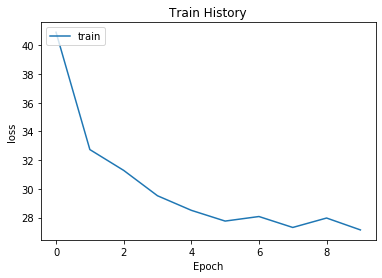

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_train_history(NN_history, train_acc):
    plt.plot(NN_history.history[train_acc])
    plt.title('Train History')
    plt.ylabel(train_acc)
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
show_train_history(train_history, 'loss')

### Multimodal

> https://github.com/leriomaggio/deep-learning-keras-tensorflow/blob/master/8.%20Extra/8.2%20Multi-Modal%20Networks.ipynb

python generator and enumerate()

> https://stackoverflow.com/questions/3396279/enumerate-ing-a-generator-in-python

fit_generator

> https://blog.csdn.net/learning_tortosie/article/details/85243310

In [50]:
def load_partial_df(batch_size=5):
#     for batch_idx in range(0, 10, batch_size):
    for batch_idx in range(0, len(img_df), batch_size):
        print(batch_idx)
        yield img_df.loc[batch_idx:batch_idx + batch_size-1]

In [56]:
# 分批load data並自動跑完全部
for i, df in enumerate(load_partial_df()):
    print(df.values[0][0])
    print(df)

0
../0806/land_streetView\120degree\新北市板橋區華東街241號_120.jpg
                                           file_path     label
0  ../0806/land_streetView\120degree\新北市板橋區華東街241...  15000000
1  ../0806/land_streetView\120degree\新北市板橋區華東街251...  15000000
2  ../0806/land_streetView\120degree\新北市板橋區華東街261...  15000000
3  ../0806/land_streetView\120degree\新北市板橋區華東街270...  15000000
4  ../0806/land_streetView\120degree\新北市板橋區華東街271...  15000000
5
../0806/land_streetView\120degree\新北市板橋區華東街281號_120.jpg
                                           file_path     label
5  ../0806/land_streetView\120degree\新北市板橋區華東街281...  15000000
6  ../0806/land_streetView\120degree\新北市板橋區華東街291...  15000000
7  ../0806/land_streetView\120degree\新北市板橋區華東街300...  15000000
8  ../0806/land_streetView\240degree\新北市板橋區華東街241...  15000000
9  ../0806/land_streetView\240degree\新北市板橋區華東街251...  15000000


In [34]:
data_generator = load_partial_df()
data_generator.__next__()

0


,file_path,label
0,../0806/land_streetView\120degree\新北市板橋區華東街241...,15000000
1,../0806/land_streetView\120degree\新北市板橋區華東街251...,15000000
2,../0806/land_streetView\120degree\新北市板橋區華東街261...,15000000
3,../0806/land_streetView\120degree\新北市板橋區華東街270...,15000000
4,../0806/land_streetView\120degree\新北市板橋區華東街271...,15000000


合成一個不支持shuffle的generator

In [72]:
img_df2 = pd.DataFrame()
img_df2['file_path'] = train_pic
img_df2['label'] = label
img_df2['area'] = area

In [29]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()

def load_partial_df(batch_size=40):
    for batch_idx in range(0, len(img_df2), batch_size):
        if batch_idx + batch_size >= len(img_df2):
            yield img_df2.loc[batch_idx:len(img_df2)-1]
        else:
            yield img_df2.loc[batch_idx:batch_idx + batch_size-1]

def load_multi_data(batch_size=40):
    genX1 = train_datagen.flow_from_dataframe(     
            dataframe=img_df2,
            batch_size= batch_size,
            x_col="file_path", 
            y_col="label",
            target_size = (img_rows, img_cols),
            shuffle=False, 
            class_mode="other")
    
    data_generator = load_partial_df(batch_size)
    
    while True:
            X1i = genX1.next()
            X2i = next(data_generator)
            yield [X1i[0], X2i['area']], X1i[1]

自己寫一個shuffle的generator

In [24]:
# Define two input layers
image_input = Input(img_size)
vector_input = Input((1,))

# Convolution + Flatten for the image
conv_layer = Conv2D(32, (5,5))(image_input)
flat_layer = Flatten()(conv_layer)

# Concatenate the convolutional features and the vector input
concat_layer= Concatenate()([vector_input, flat_layer])
output = Dense(1, activation='relu')(concat_layer)

# define a model with a list of two inputs
model = Model(inputs=[image_input, vector_input], outputs=output)
model.summary()

W0812 14:25:47.753598 18336 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 14:25:47.786597 18336 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 14:25:47.793598 18336 deprecation_wrapper.py:119] From c:\users\wade\.virtualenvs\19'_summer_vacation-ib8vnh7u\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 600, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 596, 296, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 5645312)      0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
concatenat

In [90]:
from sklearn import preprocessing

x = img_df2['label'].values 
min_max_scaler = preprocessing.MinMaxScaler()
# https://stackoverflow.com/questions/25886116/sklearns-minmaxscaler-only-returns-zeros
x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
img_df2['label'] = x_scaled

1.0

In [93]:
%%time
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
model_history = model.fit_generator(load_multi_data(), epochs=1, steps_per_epoch=img_df2.shape[0]/ 40, verbose=1)

Epoch 1/1
Found 144316 validated image filenames.
3608/3607 [==============================] - 380s 105ms/step - loss: 99.9917
Wall time: 6min 20s


### 修正方向
1. price normailize
2. 找tripAdviosr使用者關聯
3. 做CNN regression的testing

製作test data

In [35]:
test2 = pd.DataFrame(columns=['address', 'price', 'area'])
# 找出地址符合street前5000的，並幫street標上售價
for i, item in street_df[5001:5500].loc[street_df[5001:5500]['section'] == '板橋'].iterrows():
    for j, price in land_df.loc[land_df['土地區段位置/建物區段門牌'] == item['address']].iterrows():
        test2.loc[len(test2), ['address', 'price', 'area']] = item['address'], price['總價元'], price['建物移轉總面積平方公尺']
        
for m, data in street_df[5001:5500].loc[street_df[5001:5500]['section'] == '板橋'].iterrows():
    backup_num = []
    try:
        address_num = re.findall('\d+', data['address'])
        if(len(re.findall('\d+', data['address'])) > 2):
            # 存大於2個的數值(有巷/弄)
            backup_num = address_num
            # 取倒數兩個
            address_num = address_num[-2:]

        size = math.ceil((int(address_num[1]) - int(address_num[0]))/10)
        address_split = re.split('\d+', data['address'])
        address_split.remove('~')
        address_split.remove('號')
        address_template = ''.join(address_split)
        if(len(backup_num) == 3):
            #有巷
            address_split[0] = address_split[0] + backup_num[0]
            address_template = ''.join(address_split)
        if(len(backup_num) == 4):
            # 有巷也有弄
            address_split[0] = address_split[0] + backup_num[0]
            address_split[1] = address_split[1] + backup_num[1]
            address_template = ''.join(address_split)

        img_path_list = glob('../0806/land_streetView/*degree/' + address_template + '*.jpg')
        match_list = [] # 記錄有幾種照片符合規則
        price_list = [] # 此地址有多少種售價(有幾筆交易紀錄)
        for img in img_path_list:
            pattern = re.compile(address_template + '\d+號')
            if pattern.search(img):
                match_list.append(img)
                
        if not len(match_list) == 0:
            test2.loc[test2['address'] == data['address'], 'imgs'] = ','.join(match_list)
        else:
            test2.loc[test2['address'] == data['address'], 'imgs'] = ''
                
    except Exception as e:
        print(e)
        continue
        
area2 = []
train_pic2 = []
label2 = []
# 根據單一地址被交易次數與照片數，建立 train_pic list
for i, data in test2.iterrows():
    if not data['imgs']=='':
        train_pic2.extend(data['imgs'].split(','))
        # 根據 testDF同地址的不同價格數目與 unique地址的圖片產生label
        label2.extend([data['price']]*len(data['imgs'].split(',')))
        area2.extend([data['area']]*len(data['imgs'].split(',')))

In [36]:
test_df = pd.DataFrame()
test_df['file_path'] = train_pic2
test_df['label'] = label2
test_df['area'] = area2

分批讀取test

In [32]:
def load_multi_test_data(batch_size=40):
    for batch_idx in range(0, len(img_df2), batch_size):
        if batch_idx + batch_size >= len(img_df2):
            yield img_df2.loc[batch_idx:len(img_df2)-1]
        else:
            yield img_df2.loc[batch_idx:batch_idx + batch_size-1]

def load_multi_test_data(batch_size=40):
    genX1 = train_datagen.flow_from_dataframe(     
            dataframe=test_df,
            batch_size= batch_size,
            x_col="file_path", 
            y_col="label",
            target_size = (img_rows, img_cols),
            shuffle=False, 
            class_mode="other")
    
#     data_generator = load_multi_test_data(batch_size)
    
    while True:
            X1i = genX1.next()
#             X2i = next(data_generator)
            yield X1i[0], X1i[1]
#             yield [X1i[0], X2i['area']], X1i[1]

evaluate model

In [37]:
model_CNN.evaluate_generator(load_multi_test_data(), steps=test_df.shape[0]/40)

Found 7422 validated image filenames.


59.41812339788883